In [27]:
install.packages("glmnet")
install.packages("caret")
install.packages("dplyr")



The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpxIyZJh/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpxIyZJh/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmpxIyZJh/downloaded_packages


In [26]:
library(glmnet)
library(caret)
library(dplyr)

# Import and format data

In [43]:
#read in the data
data <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/fieldwork_regression_table.csv")
#check col names and structure
names(data)
str(data)
#new df without extra cols
trim_data <- data %>% select(-identifier, -score_min, -score_ellen, -score_aadya, -serviceable_ellen, -serviceable_aadya)
trim_data <- trim_data %>% select(-IT01V_frameHeight_ellen, -IT01V_frameHeight_aadya )


[1] "identifier"                                        
 [2] "IT01V_packetsRecieved_ellen"                       
 [3] "IT01V_packetsRecieved_aadya"                       
 [4] "IT01V_packetsLost_ellen"                           
 [5] "IT01V_packetsLost_aadya"                           
 [6] "IT01V_frameWidth_ellen"                            
 [7] "IT01V_frameWidth_aadya"                            
 [8] "IT01V_frameHeight_ellen"                           
 [9] "IT01V_frameHeight_aadya"                           
[10] "IT01V_totalFreezesDuration_ellen"                  
[11] "IT01V_totalFreezesDuration_aadya"                  
[12] "IT01V_framesPerSecond_ellen"                       
[13] "IT01V_framesPerSecond_aadya"                       
[14] "IT01V_bytesReceived_in_bits_s_ellen"               
[15] "IT01V_bytesReceived_in_bits_s_aadya"               
[16] "IT01V_totalProcessingDelay_ellen"                  
[17] "IT01V_totalProcessingDelay_aadya"                  
[18] "IT01V_jitter_ellen"                                
[19] "IT01V_jitter_aadya"                                
[20] "IT01V_jitterBufferDelay_emissions_ellen"           
[21] "IT01V_jitterBufferDelay_emissions_aadya"           
[22] "IT01A_bytesReceived_in_bits_s_ellen"               
[23] "IT01A_bytesReceived_in_bits_s_aadya"               
[24] "IT01A_jitterBufferDelay_emissions_ellen"           
[25] "IT01A_jitterBufferDelay_emissions_aadya"           
[26] "OT01V_packetsSent_s_ellen"                         
[27] "OT01V_packetsSent_s_aadya"                         
[28] "OT01V_bytesSent_in_bits_s_ellen"                   
[29] "OT01V_bytesSent_in_bits_s_aadya"                   
[30] "OT01V_frameWidth_ellen"                            
[31] "OT01V_frameWidth_aadya"                            
[32] "OT01V_framesPerSecond_ellen"                       
[33] "OT01V_framesPerSecond_aadya"                       
[34] "OT01V_totalPacketSendDelay_ellen"                  
[35] "OT01V_totalPacketSendDelay_aadya"                  
[36] "OT01V_totalPacketSendDelay_packetsSent_in_ms_ellen"
[37] "OT01V_totalPacketSendDelay_packetsSent_in_ms_aadya"
[38] "RIV_roundTripTime_ellen"                           
[39] "RIV_roundTripTime_aadya"                           
[40] "RIV_fractionLost_ellen"                            
[41] "RIV_fractionLost_aadya"                            
[42] "RIA_fractionLost_ellen"                            
[43] "RIA_fractionLost_aadya"                            
[44] "RIA_roundTripTime_ellen"                           
[45] "RIA_roundTripTime_aadya"                           
[46] "ROA_roundTripTime_ellen"                           
[47] "ROA_roundTripTime_aadya"                           
[48] "AP_totalPlayoutDelay_ellen"                        
[49] "AP_totalPlayoutDelay_aadya"                        
[50] "score_ellen"                                       
[51] "score_aadya"                                       
[52] "score_min"                                         
[53] "serviceable_ellen"                                 
[54] "serviceable_aadya"                                 
[55] "serviceable_agg"

'data.frame':	90 obs. of  55 variables:
 $ identifier                                        : chr  "colac12" "colac23" "colac31" "dunkeld12" ...
 $ IT01V_packetsRecieved_ellen                       : num  164.5 25.2 135.8 138.5 105.7 ...
 $ IT01V_packetsRecieved_aadya                       : num  84.5 20 154.5 38 44 ...
 $ IT01V_packetsLost_ellen                           : num  7.2 0 10 0 0 0 0 0 0 0 ...
 $ IT01V_packetsLost_aadya                           : num  9 0 4 28 0 2 0 0 0 0 ...
 $ IT01V_frameWidth_ellen                            : num  1280 480 1280 1280 960 480 960 960 1280 1280 ...
 $ IT01V_frameWidth_aadya                            : num  1280 320 1280 1280 640 640 960 1280 1280 960 ...
 $ IT01V_frameHeight_ellen                           : num  720 270 720 720 540 270 540 540 720 720 ...
 $ IT01V_frameHeight_aadya                           : num  720 180 720 720 360 360 540 720 720 540 ...
 $ IT01V_totalFreezesDuration_ellen                  : num  0 1.264 0 0.875 0.2

Divide into train and test

In [44]:
set.seed(6)  # for reproducibility
train_index <- createDataPartition(trim_data$serviceable_agg, p = 0.7, list = FALSE)
train_data <- trim_data[train_index, ]
test_data <- trim_data[-train_index, ]

format as matrices for fitting

In [45]:
x_train <- as.matrix(train_data[, -which(names(train_data) == "serviceable_agg")])
y_train <- train_data$serviceable_agg

x_test <- as.matrix(test_data[, -which(names(test_data) == "serviceable_agg")])
y_test <- test_data$erviceable_agg


# Approach 1: Setting alpha manually

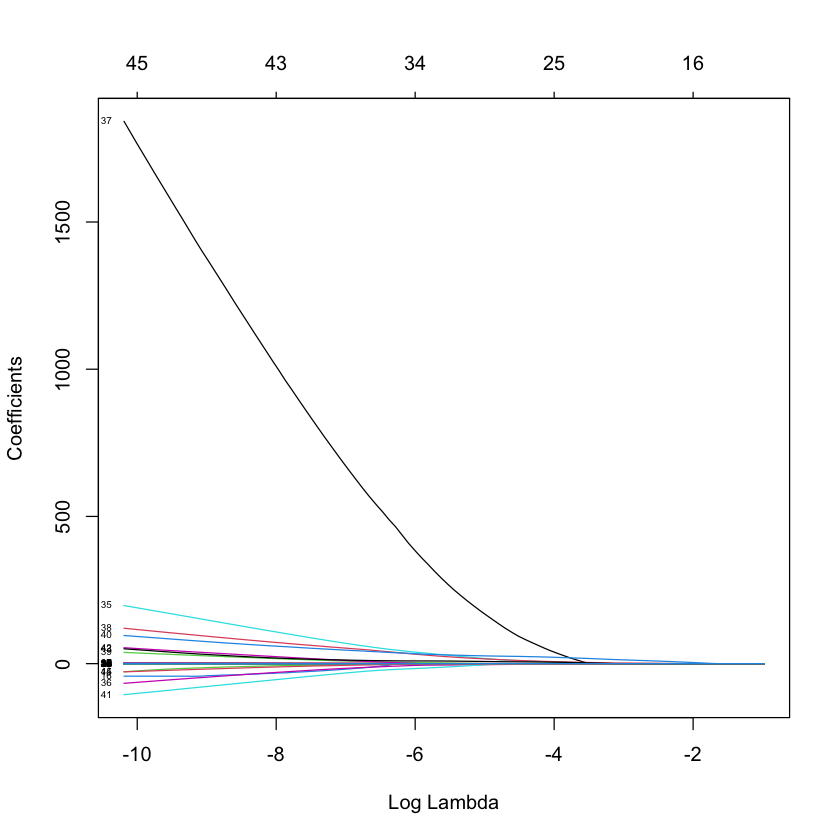

47 x 1 sparse Matrix of class "dgCMatrix"
                                                              s0
(Intercept)                                        -5.203709e+00
IT01V_packetsRecieved_ellen                         .           
IT01V_packetsRecieved_aadya                         7.639572e-04
IT01V_packetsLost_ellen                            -4.724936e-02
IT01V_packetsLost_aadya                             8.339575e-02
IT01V_frameWidth_ellen                              6.110714e-04
IT01V_frameWidth_aadya                              .           
IT01V_totalFreezesDuration_ellen                    .           
IT01V_totalFreezesDuration_aadya                    .           
IT01V_framesPerSecond_ellen                         1.441094e-02
IT01V_framesPerSecond_aadya                         3.931852e-02
IT01V_bytesReceived_in_bits_s_ellen                 .           
IT01V_bytesReceived_in_bits_s_aadya                 .           
IT01V_totalProcessingDelay_ellen                

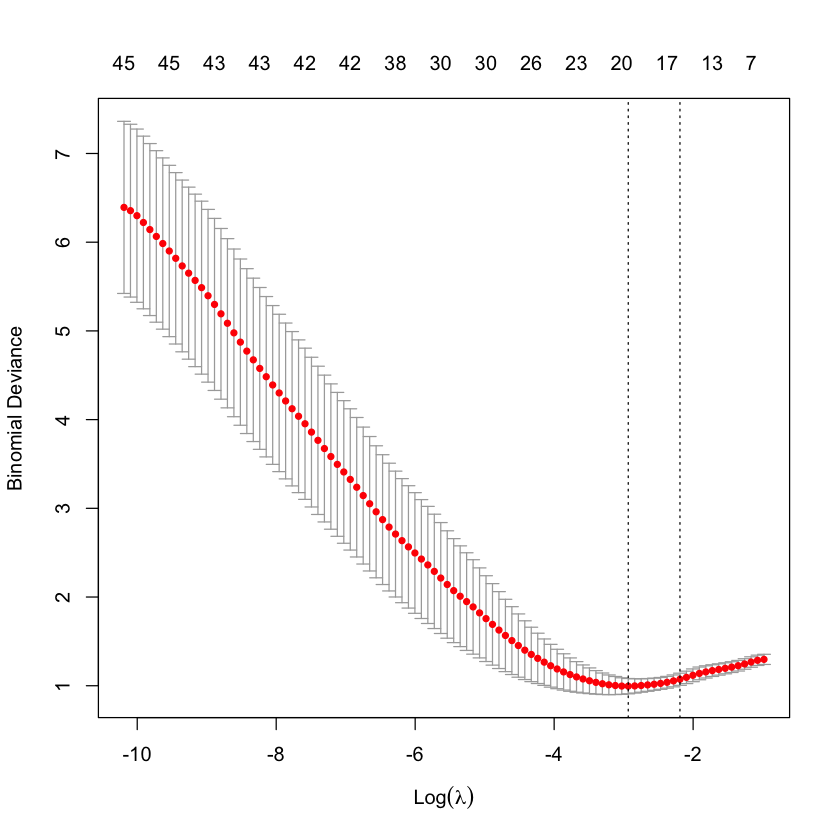

In [47]:
# alpha = 0.5(elastic net)
par(bg= "white")
model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the coefficient paths
plot(model_manual, xvar = "lambda", label = TRUE)

# Perform cross-validation to find the optimal lambda
cv_model_manual <- cv.glmnet(x_train, y_train, family = "binomial", alpha = 0.5)

# Plot the cross-validation curve
plot(cv_model_manual)

# Get the best lambda
best_lambda <- cv_model_manual$lambda.min

# Fit the final model with the best lambda
final_model_manual <- glmnet(x_train, y_train, family = "binomial", alpha = 0.5, lambda = best_lambda)

# Print the coefficients
coef(final_model_manual)

### Summary of output

In [48]:
#isolate only the vars it selected
selected_vars <- rownames(coef(final_model_manual))[-1][coef(final_model_manual)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("serviceable_agg ~", paste(selected_vars, collapse = " + ")))

# Fit a standard logistic regression model
logistic_model <- glm(formula, data = train_data, family = "binomial")
summary(logistic_model)


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = formula, family = "binomial", data = train_data)

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                             -1.191e+01  4.133e+01  -0.288   0.7731
IT01V_packetsRecieved_aadya              9.815e-03  2.583e-02   0.380   0.7040
IT01V_packetsLost_ellen                 -1.632e+00  1.281e+00  -1.274   0.2028
IT01V_packetsLost_aadya                  1.256e+00  7.850e-01   1.600   0.1095
IT01V_frameWidth_ellen                   1.493e-01  1.071e+01   0.014   0.9889
IT01V_framesPerSecond_ellen             -2.089e+00  1.792e+00  -1.166   0.2436
IT01V_framesPerSecond_aadya              1.144e+00  9.982e-01   1.146   0.2518
IT01V_totalProcessingDelay_ellen         1.796e-01  1.234e-01   1.456   0.1454
IT01V_totalProcessingDelay_aadya        -2.854e-01  1.731e-01  -1.649   0.0992
IT01V_jitterBufferDelay_emissions_ellen -1.311e-01  8.161e-02  -1.606   0.1082
IT01V_jitterBufferDelay_emissions_aadya  6.931